In [13]:
import os
import glob
import torch.nn.functional as F
import networkx
import torch
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from torch.utils.data import Dataset

# def normalize(y):
# 	m1 = y.mean(axis=(1,0))
# 	s1 = y.std(axis=(1,0))
# 	return (y-m1)/s1

def normalize(y):
    max_norm = np.max(np.linalg.norm(y, axis=-1))
    return y/max_norm
	# return y

# def normalize(y):
#     left_wr = y[5,:]
#     y = y - left_wr
#     y = rotate_and_normalize(y)
#     return y

# def rotation_matrix_from_vectors(vec1, vec2):
#     """Find the rotation matrix that aligns vec1 to vec2."""
#     a = vec1 / np.linalg.norm(vec1)
#     b = vec2 / np.linalg.norm(vec2)
#     v = np.cross(a, b)
#     c = np.dot(a, b)
#     s = np.linalg.norm(v)
    
#     if s == 0:
#         return np.eye(3)  # Already aligned
    
#     vx = np.array([[0, -v[2], v[1]],
#                    [v[2], 0, -v[0]],
#                    [-v[1], v[0], 0]])
#     R = np.eye(3) + vx + vx @ vx * ((1 - c) / (s ** 2))
#     return R

# def rotate_and_normalize(y):
#     """Rotate and normalize the vectors so that y[20] aligns with (1,0,0)."""
    
#     target = np.array([1, 0, 0])
#     R = rotation_matrix_from_vectors(y[20,:], target)

#     y = y / np.linalg.norm(y[20,:])  # Normalize  
#     y = (R @ y.T).T  # Apply rotation
#     return y

def equalize_ndarray(arr, axis=0, target_size=None):
	"""
	Equalize a numpy ndarray along a specified axis by undersampling or uppersampling by a fixed quantity.
	
	Parameters:
	arr (numpy.ndarray): Input array to be equalized.
	axis (int): Axis along which to equalize the array.
	target_size (int): Target size for the specified axis. If None, the size of the smallest dimension along the axis is used.
	
	Returns:
	numpy.ndarray: Equalized array.
	"""
      
	if target_size is None:
		target_size = min(arr.shape[axis])
	
	current_size = arr.shape[axis]
	indices = np.arange(current_size)
      
	delta_t = target_size/current_size
	
	if current_size > target_size:
		# Undersampling
		indices = np.linspace(0, current_size - 1, target_size).astype(int)
	elif current_size < target_size:
		# Oversampling
		indices = np.linspace(0, current_size - 1, target_size).astype(int)
	
	equalized_arr = np.take(arr, indices, axis=axis)
	return equalized_arr, delta_t

def compute_velocity(points, delta_t=1):
	"""
	Compute the velocity among 3D points in a matrix.
	
	Args:
	points (np.ndarray): A numpy array of shape (N, 3) where N is the number of points and each point has 3 coordinates (x, y, z).
	
	Returns:
	np.ndarray: A numpy array of shape (N-1, 3) representing the velocity between consecutive points.
	"""
	velocities = (points[1:] - points[:-1])*delta_t
	norm_points = np.max(np.linalg.norm(points, axis=-1))
	return velocities/norm_points

def add_ohe(points):
	ohe = np.repeat(np.expand_dims(np.eye(points.shape[1]), axis=0), points.shape[0], axis=0)
	points = np.concatenate([points, ohe], axis=-1)
	return points

def load_files(folder_path, compute_velocity_b=True, equalize=True, ohe = False, target_size=100):

	# load train, val and test data	
	pattern = os.path.join(folder_path, '*.npy')
	file_names = glob.glob(pattern)
	print(pattern)
	data = []
	temp_index = [0]
	for file in file_names:
		d = np.load(file)
		# d = d.transpose(0,1,3,2)[:,:,0,:]
		d = d.transpose(0,1,3,2).reshape((d.shape[0], d.shape[1], d.shape[2]*d.shape[3]))
		d = np.transpose(d, (1, 2, 0)) # (t, n, 3)

		temp_index.append(d.shape[0]+temp_index[-1])

		if equalize:
			d, delta_t = equalize_ndarray(d, axis=0, target_size=target_size)
		
		for i in range(d.shape[0]):
			d[i] = normalize(d[i])
		
		# add velocity
		if compute_velocity_b and equalize:
			d = np.pad(d, ((0, 0), (0, 0), (0, 3)), mode='constant', constant_values=0)
			velocities = compute_velocity(d[:, :, :3], delta_t) # type: ignore
			d[1:, :, 3:] = velocities

		if ohe:
			d = add_ohe(d)	

		distances = np.linalg.norm(np.diff(d, axis=0), axis=2)  # Shape (t-1, n)
		distances = np.sum(distances, axis=1)
		if np.max(distances)<5:
			data.append(d)

	# data = np.array(data, dtype = np.float32)
	
	print("Data len: ", len(data))
	return data, temp_index


In [14]:
from tsl.data import SpatioTemporalDataset
from tsl.data.datamodule import SpatioTemporalDataModule, Splitter
from typing import Union

path = "/home/studenti/agnelli/projects/4D_hands/Assembly/nri/data"
data, temp_index = load_files(path, compute_velocity_b=True, equalize=False)
# data = data.reshape(-1, 42, 3)
data = np.concatenate(data, axis=0)
edge_index = torch.tensor([[4,19],[3,16],[2,13],[1,10],[19,18],[16,15],[13,12],[10,9],[18,17],[15,14],[12,11],[9,8],[17,5],[14,5],[11,5],[8,5],[0,7],[7,6],[6,5],[20,5],[17,14],[14,11],[11,8]])
edge_index = torch.cat([edge_index,edge_index+21], dim=0).permute(1,0)
edge_weight = torch.ones(edge_index.shape[1])
adj = (edge_index, edge_weight)

torch_dataset = SpatioTemporalDataset(target=data, # type: ignore
                                      index=temp_index, # type: ignore
                                      connectivity=[adj],   # type: ignore                                    
                                      horizon=20,
                                      window=80,
                                      stride=1)
print(torch_dataset)

class AssemblySplitter(Splitter):
    def __init__(self,
                 val_lenght: Union[int, float] = 0.1,
                 test_lenght: Union[int, float] = 0.1):
        super(AssemblySplitter, self).__init__()
        self.val_lenght = val_lenght
        self.test_lenght = test_lenght

    def fit(self, dataset: SpatioTemporalDataset):

        test_len = int(self.test_lenght*len(dataset.index)) # type: ignore
        val_len = int(self.val_lenght*len(dataset.index)) # type: ignore
        tr_index_split = dataset.index[:int(len(dataset.index))-test_len-val_len] # type: ignore
        val_index_split = dataset.index[int(len(dataset.index))-test_len-val_len-1:int(len(dataset.index))-test_len] # type: ignore
        test_index_split = dataset.index[int(len(dataset.index))-test_len-1:] # type: ignore
        
        train_idxs = []
        if len(tr_index_split) > 1:
            for i in range(len(tr_index_split)-1):
                first_time, last_time = tr_index_split[i], tr_index_split[i+1]-dataset.horizon-dataset.window # type: ignore
                if (last_time - first_time) > 0:
                    indices_after = first_time <= dataset.indices
                    indices_before = dataset.indices < last_time
                    indices = np.nonzero(indices_after & indices_before).ravel()
                    train_idxs.append(indices)
        # convert list of arrays to a single array
        train_idxs = np.concatenate(train_idxs).ravel()
        
        val_idxs = []
        if len(val_index_split) > 1:
            for i in range(len(val_index_split)-1):
                first_time, last_time = val_index_split[i], val_index_split[i+1]-dataset.horizon-dataset.window # type: ignore
                if (last_time - first_time) > 0:
                    indices_after = first_time <= dataset.indices
                    indices_before = dataset.indices < last_time
                    indices = np.nonzero(indices_after & indices_before).ravel()
                    val_idxs.append(indices)
        val_idxs = np.concatenate(val_idxs).ravel()

        test_idxs = []
        if len(test_index_split) > 1:
            for i in range(len(test_index_split)-1):
                first_time, last_time = test_index_split[i], test_index_split[i+1]-dataset.horizon-dataset.window # type: ignore
                if (last_time - first_time) > 0:
                    indices_after = first_time <= dataset.indices
                    indices_before = dataset.indices < last_time
                    indices = np.nonzero(indices_after & indices_before).ravel()
                    test_idxs.append(indices)
        test_idxs = np.concatenate(test_idxs).ravel()
        
        self.set_indices(train_idxs, val_idxs, test_idxs)

# Normalize data using mean and std computed over time and node dimensions
splitter = AssemblySplitter(val_lenght=0.1, test_lenght=0.1)

dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    # scalers=scalers,
    splitter=splitter,
    batch_size=512,
)

dm.setup()
print(dm)

/home/studenti/agnelli/projects/4D_hands/Assembly/nri/data/*.npy
Data len:  3478
SpatioTemporalDataset(n_samples=572183, n_nodes=42, n_channels=3)
{Train dataloader: size=203086}
{Validation dataloader: size=22145}
{Test dataloader: size=0}
{Predict dataloader: None}


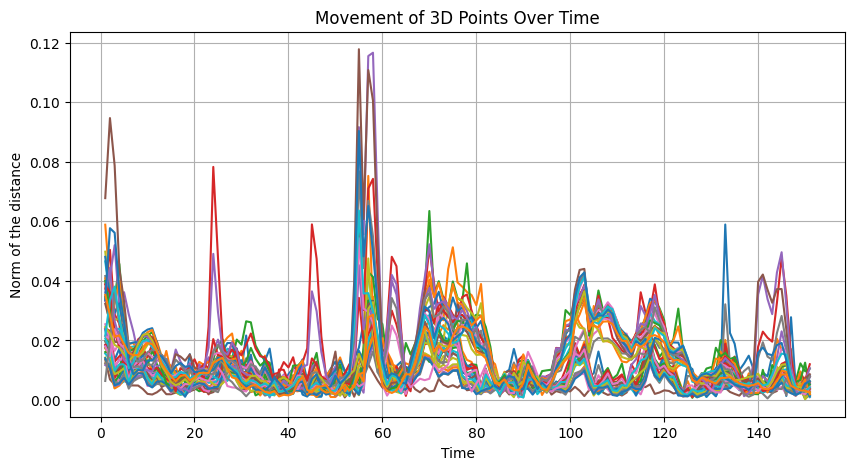

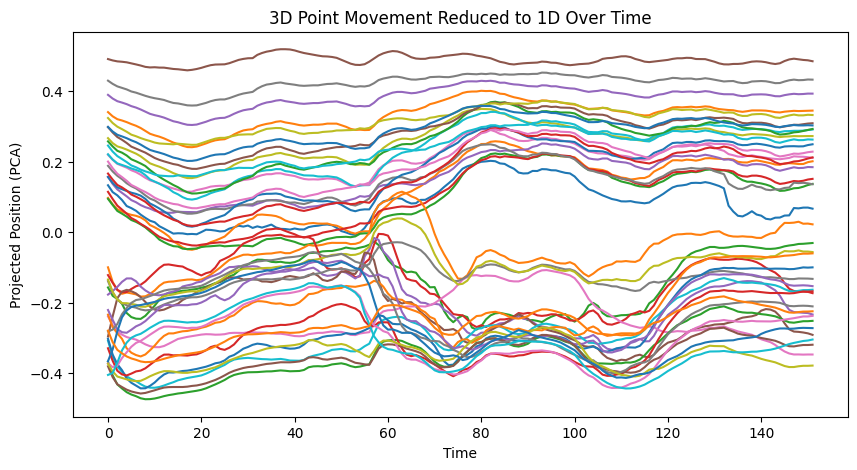

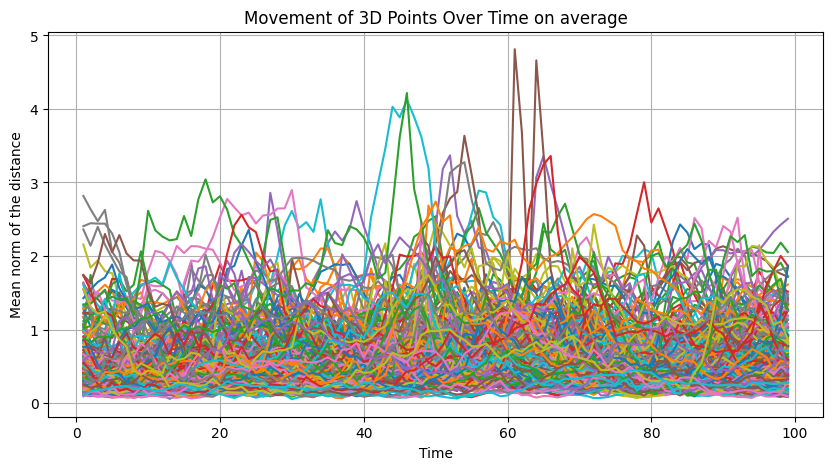

In [16]:
# path = "/home/studenti/agnelli/projects/4D_hands/Assembly/nri/data"
# data, temp_index = load_files(path, compute_velocity_b=True, equalize=False)

# import numpy as np
# import matplotlib.pyplot as plt

# n = 42
# y = data[3]
# t = y.shape[0]
# distances = np.linalg.norm(np.diff(y, axis=0), axis=2)  # Shape (t-1, n)

# # Plot
# plt.figure(figsize=(10, 5))
# for i in range(n):
#     plt.plot(range(1, t), distances[:, i], label=f'Point {i+1}')

# plt.xlabel('Time')
# plt.ylabel('Norm of the distance')
# plt.title('Movement of 3D Points Over Time')
# plt.grid()
# plt.show()

# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# # Flatten y over time to fit PCA (concatenating all time steps)
# # y = train_data[952]
# y_reshaped = y.reshape(t * n, 3)

# # Apply PCA to reduce 3D to 1D
# pca = PCA(n_components=1)
# y_pca = pca.fit_transform(y_reshaped).reshape(t, n)  # Reshape back to (t, n)

# # Plot the PCA-transformed values over time
# plt.figure(figsize=(10, 5))
# for i in range(n):
#     plt.plot(range(t), y_pca[:, i], label=f'Point {i+1}')

# plt.xlabel("Time")
# plt.ylabel("Projected Position (PCA)")
# plt.title("3D Point Movement Reduced to 1D Over Time")
# plt.show()


# mean_distance = []
# i = 0
# for land in data:
#     distances = np.linalg.norm(np.diff(land, axis=0), axis=2)  # Shape (t-1, n)
#     mean_distance.append(np.sum(distances, axis=1))
#     if np.max(mean_distance[i])>20:
#         print("Big distance at sample", i, "with value ", np.max(mean_distance[i]))
#     i += 1

# # Plot
# plt.figure(figsize=(10, 5))
# for i in range(200):
#     plt.plot(range(1, 100), mean_distance[i][1:100])

# plt.xlabel('Time')
# plt.ylabel('Mean norm of the distance')
# plt.title('Movement of 3D Points Over Time on average')
# plt.grid()
# plt.show()

In [7]:
import plotly.graph_objects as go

landmarks = torch_dataset[0].y
A = edge_index.permute(1,0)
n=0

# Create the initial 3D scatter plot
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=landmarks[n][:, 0],
            y=landmarks[n][:, 1],
            z=landmarks[n][:, 2],
            mode='markers',
            marker=dict(size=2, color="red", opacity=0.7)
        )]+[
        go.Scatter3d(
                    x=[landmarks[n][i, 0], landmarks[n][j, 0]],
                    y=[landmarks[n][i, 1], landmarks[n][j, 1]],
                    z=[landmarks[n][i, 2], landmarks[n][j, 2]],
                    mode='lines',
                    line=dict(color='blue', width=1),
                ) for i, j in A  # Adjacency matrix updates per frame
    ]+[
        go.Scatter3d(
            x=landmarks[n][20:21, 0],
            y=landmarks[n][20:21, 1],
            z=landmarks[n][20:21, 2],
            mode='markers',
            marker=dict(size=2, color="black", opacity=0.7)
        )],
    layout=go.Layout(
        title="Evolution of landmarks",
        # scene=dict(
        #     xaxis=dict(range=[-3, 3]),  # Set appropriate axis ranges
        #     yaxis=dict(range=[-3, 3]),
        #     zaxis=dict(range=[-3, 3]),
        #     aspectmode="cube"  # Ensures equal scaling for all axes
        # ),
        updatemenus=[{
            "buttons": [
                {"args": [None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}],
                 "label": "Play",
                 "method": "animate"},
                {"args": [[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}],
                 "label": "Pause",
                 "method": "animate"}
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }]
    ),
    frames=[
        go.Frame(
            data=[
                go.Scatter3d(
                    x=landmarks[t][:, 0],
                    y=landmarks[t][:, 1],
                    z=landmarks[t][:, 2],
                    mode='markers',
                    marker=dict(size=2, color="red", opacity=0.7)
                )
            ] + [
                go.Scatter3d(
                    x=[landmarks[t][i, 0], landmarks[t][j, 0]],
                    y=[landmarks[t][i, 1], landmarks[t][j, 1]],
                    z=[landmarks[t][i, 2], landmarks[t][j, 2]],
                    mode='lines',
                    line=dict(color='blue', width=1),
                ) for i, j in A  # Adjacency matrix updates per frame
            ] + [
                go.Scatter3d(
                    x=landmarks[t][20:21, 0],
                    y=landmarks[t][20:21, 1],
                    z=landmarks[t][20:21, 2],
                    mode='markers',
                    marker=dict(size=2, color="red", opacity=0.7)
                )
            ],
            name=f"Frame {n+t}"
        ) for t in range(n, len(landmarks))
    ]
)

# Show the animated plot
fig.show()

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.utils import dense_to_sparse
from tsl.nn.blocks.encoders import RNN
from tsl.nn.layers import NodeEmbedding, DiffConv
from einops.layers.torch import Rearrange  # reshape data with Einstein notation

def print_model_size(model):
    tot = sum([p.numel() for p in model.parameters() if p.requires_grad])
    out = f"Number of model ({model.__class__.__name__}) parameters:{tot:10d}"
    print("=" * len(out))
    print(out)

class TimeThenSpaceModel(nn.Module):
    def __init__(self, input_size: int, n_nodes: int, horizon: int,
                 hidden_size: int = 32,
                 t_layers: int = 1,
                 gnn_kernel: int = 2):
        super(TimeThenSpaceModel, self).__init__()

        self.encoder = nn.Linear(input_size, hidden_size)

        self.node_embeddings = NodeEmbedding(n_nodes, hidden_size)

        self.time_nn = RNN(input_size=hidden_size,
                    hidden_size=hidden_size,
                    n_layers=t_layers,
                    cell='gru',
                    return_only_last_state=True)

        self.space_nn = DiffConv(in_channels=hidden_size,
                                 out_channels=hidden_size,
                                 k=gnn_kernel)

        self.decoder = nn.Linear(hidden_size, input_size * horizon)
        self.rearrange = Rearrange('b n (t f) -> b t n f', t=horizon)

    def forward(self, x, edge_index, edge_weight = None):
        # x: [batch time nodes features]
        x_enc = self.encoder(x)  # linear encoder: x_enc = xΘ + b
        x_emb = x_enc + self.node_embeddings()  # add node-identifier embeddings
        h = self.time_nn(x_emb)  # temporal processing: x=[b t n f] -> h=[b n f]
        z = self.space_nn(h, edge_index)  # spatial processing
        x_out = self.decoder(z)  # linear decoder: z=[b n f] -> x_out=[b n t⋅f]
        x_horizon = self.rearrange(x_out)
        return x_horizon

def train(model, train_loader, criterion, optimizer, metric, device, epochs=10, scheduler=None, log_dir="runs"):
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_metric = 0.0
        total_samples = 0
        
        for batch in train_loader:
            inputs, targets = batch.input.to(device), batch.target.to(device)
            x = inputs.x
            # edge_index = dense_to_sparse(inputs.edge_index.to(dtype=torch.long))[0]
            edge_index = inputs.edge_index.to(dtype=torch.long)

            optimizer.zero_grad()
            outputs = model(x, edge_index)
            diff_pred = torch.norm(outputs[:,:,edge_index[0], :3]-outputs[:,:,edge_index[1], :3], dim = -1)
            diff_true = torch.norm(targets.y[:,:,edge_index[0], :3]-targets.y[:,:,edge_index[1], :3], dim = -1)
            loss = criterion(outputs, targets.y) + criterion(diff_pred, diff_true)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * x.size(0)
            running_metric += metric(outputs, targets.y).item() * x.size(0)
            total_samples += x.size(0)

        epoch_loss = running_loss / total_samples
        epoch_metric = running_metric / total_samples

        if scheduler is not None:
            scheduler.step(epoch_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Metric: {epoch_metric:.4f}")

def test(model, test_loader, criterion, metric, device, log_dir="runs"):
    model.to(device)
    model.eval()

    running_loss = 0.0
    running_metric = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch.input.to(device), batch.target.to(device)
            x = inputs.x
            # edge_index = dense_to_sparse(inputs.edge_index.to(dtype=torch.long))[0]
            edge_index = inputs.edge_index.to(dtype=torch.long)

            outputs = model(x, edge_index)
            loss = criterion(outputs, targets.y)
            
            running_loss += loss.item() * x.size(0)
            running_metric += metric(outputs, targets.y).item() * x.size(0)
            total_samples += x.size(0)

    epoch_loss = running_loss / total_samples
    epoch_metric = running_metric / total_samples

    print(f"Test Loss: {epoch_loss:.4f}, Test Metric: {epoch_metric:.4f}")

hidden_size = 128   #@param
t_layers = 3     #@param
gnn_kernel = 3     #@param

input_size = torch_dataset.n_channels   # 1 channel
n_nodes = torch_dataset.n_nodes         # 207 nodes
horizon = torch_dataset.horizon         # 12 time steps

stgnn = TimeThenSpaceModel(input_size=input_size,
                           n_nodes=n_nodes,
                           horizon=horizon,
                           hidden_size=hidden_size,
                           t_layers=t_layers,
                           gnn_kernel=gnn_kernel)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
learning_rate = 0.001
epochs = 20

# Data loaders
train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

criterion = nn.MSELoss()
metric = nn.L1Loss()
optimizer = torch.optim.Adam(stgnn.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Train and test the model
train(stgnn, train_loader, criterion, optimizer, metric, device, epochs, scheduler)
test(stgnn, test_loader, criterion, metric, device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 17.41 GiB. GPU 0 has a total capacity of 79.25 GiB of which 16.55 GiB is free. Process 72249 has 24.97 GiB memory in use. Including non-PyTorch memory, this process has 37.73 GiB memory in use. Of the allocated memory 19.85 GiB is allocated by PyTorch, and 17.38 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

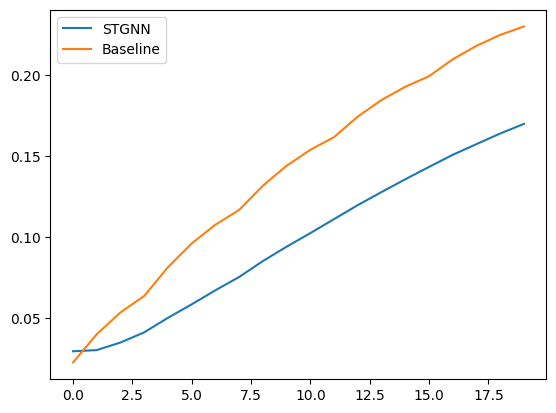

In [ ]:
# baseline predicting a constant value
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

def test_baseline(model, test_loader, device):

    model.to(device)

    score = []
    score_base = []

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch.input.to(device), batch.target.to(device)
            x = inputs.x

            outputs_base = x[:,-1,:,:].unsqueeze(1).expand(x.shape[0], targets.y.shape[1], x.shape[2], x.shape[3])
            score_base.append(torch.norm(outputs_base-targets.y, dim=-1).mean(dim=(2)))
            
            edge_index = inputs.edge_index.to(dtype=torch.long).to(device)
            outputs = model(x, edge_index)
            score.append(torch.norm(outputs-targets.y, dim=-1).mean(dim=(2)))
    
    score = torch.cat(score, dim=0).mean(0)
    score_base = torch.cat(score_base, dim=0).mean(0)

    return score, score_base

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train and test the model
score, score_base = test_baseline(stgnn, test_loader, device)

# plot in the same figure score and score_base to compare them

score = score.cpu().numpy()
score_base = score_base.cpu().numpy()

plt.plot(score, label="STGNN")
plt.plot(score_base, label="Baseline")
plt.legend()
plt.show()

In [ ]:
import plotly.graph_objects as go

for batch in test_loader:
    with torch.no_grad():
        inputs, targets = batch.input.to(device), batch.target.to(device)
        x = inputs.x
        edge_index = inputs.edge_index.to(dtype=torch.long)
        outputs = stgnn(x, edge_index)
        landmarks_pred = outputs.cpu().numpy()[20]
        landmarks_true = targets.y.cpu().numpy()[20]
    break
    
A = edge_index.permute(1,0).cpu().numpy()
n=0

# Create the initial 3D scatter plot
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=landmarks_pred[n][:, 0],
            y=landmarks_pred[n][:, 1],
            z=landmarks_pred[n][:, 2],
            mode='markers',
            marker=dict(size=2, color="red", opacity=0.7)
        )]+[
        go.Scatter3d(
                    x=[landmarks_pred[n][i, 0], landmarks_pred[n][j, 0]],
                    y=[landmarks_pred[n][i, 1], landmarks_pred[n][j, 1]],
                    z=[landmarks_pred[n][i, 2], landmarks_pred[n][j, 2]],
                    mode='lines',
                    line=dict(color="red", width=1),
                ) for i, j in A  # Adjacency matrix updates per frame
    ]+[
        go.Scatter3d(
            x=landmarks_true[n][:, 0],
            y=landmarks_true[n][:, 1],
            z=landmarks_true[n][:, 2],
            mode='markers',
            marker=dict(size=2, color="blue", opacity=0.7)
        )] + [
                go.Scatter3d(
                    x=[landmarks_true[0][i, 0], landmarks_true[0][j, 0]],
                    y=[landmarks_true[0][i, 1], landmarks_true[0][j, 1]],
                    z=[landmarks_true[0][i, 2], landmarks_true[0][j, 2]],
                    mode='lines',
                    line=dict(color='blue', width=1),
                ) for i, j in A  # Adjacency matrix updates per frame
            ],
    layout=go.Layout(
        title="Evolution of landmarks",
        # scene=dict(
        #     xaxis=dict(range=[-3, 3]),  # Set appropriate axis ranges
        #     yaxis=dict(range=[-3, 2]),
        #     zaxis=dict(range=[-1, 3]),
        #     aspectmode="cube"  # Ensures equal scaling for all axes
        # ),
        updatemenus=[{
            "buttons": [
                {"args": [None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}],
                 "label": "Play",
                 "method": "animate"},
                {"args": [[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}],
                 "label": "Pause",
                 "method": "animate"}
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }]
    ),
    frames=[
        go.Frame(
            data=[
                go.Scatter3d(
                    x=landmarks_pred[t][:, 0],
                    y=landmarks_pred[t][:, 1],
                    z=landmarks_pred[t][:, 2],
                    mode='markers',
                    marker=dict(size=2, color="red", opacity=0.7)
                )
            ] + [
                go.Scatter3d(
                    x=[landmarks_pred[t][i, 0], landmarks_pred[t][j, 0]],
                    y=[landmarks_pred[t][i, 1], landmarks_pred[t][j, 1]],
                    z=[landmarks_pred[t][i, 2], landmarks_pred[t][j, 2]],
                    mode='lines',
                    line=dict(color="red", width=1),
                ) for i, j in A  # Adjacency matrix updates per frame
            ] + [
                go.Scatter3d(
                    x=landmarks_true[t][:, 0],
                    y=landmarks_true[t][:, 1],
                    z=landmarks_true[t][:, 2],
                    mode='markers',
                    marker=dict(size=2, color="blue", opacity=0.7)
                )
            ] + [
                go.Scatter3d(
                    x=[landmarks_true[t][i, 0], landmarks_true[t][j, 0]],
                    y=[landmarks_true[t][i, 1], landmarks_true[t][j, 1]],
                    z=[landmarks_true[t][i, 2], landmarks_true[t][j, 2]],
                    mode='lines',
                    line=dict(color='blue', width=1),
                ) for i, j in A  # Adjacency matrix updates per frame
            ],
            name=f"Frame {n+t}"
        ) for t in range(n, len(landmarks_pred))
    ]
)

# Show the animated plot
fig.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np
import imageio.v2 as imageio  # Use imageio.v2 for compatibility
import os

# Ensure you have the required data
n = 0  # Initial frame index

# Define output folder for frames
output_folder = "animation_frames"
os.makedirs(output_folder, exist_ok=True)

# Generate frames for animation
frames = []
for t in range(n, len(landmarks_pred)):
    # Create the initial 3D scatter plot
    fig = go.Figure(
        data=[go.Scatter3d(
                        x=landmarks_pred[t][:, 0],
                        y=landmarks_pred[t][:, 1],
                        z=landmarks_pred[t][:, 2],
                        mode='markers',
                        marker=dict(size=2, color="red", opacity=0.7)
                    )
                ] + [
                    go.Scatter3d(
                        x=[landmarks_pred[t][i, 0], landmarks_pred[t][j, 0]],
                        y=[landmarks_pred[t][i, 1], landmarks_pred[t][j, 1]],
                        z=[landmarks_pred[t][i, 2], landmarks_pred[t][j, 2]],
                        mode='lines',
                        line=dict(color="red", width=1),
                    ) for i, j in A  # Adjacency matrix updates per frame
                ] + [
                    go.Scatter3d(
                        x=landmarks_true[t][:, 0],
                        y=landmarks_true[t][:, 1],
                        z=landmarks_true[t][:, 2],
                        mode='markers',
                        marker=dict(size=2, color="blue", opacity=0.7)
                    )
                ] + [
                    go.Scatter3d(
                        x=[landmarks_true[t][i, 0], landmarks_true[t][j, 0]],
                        y=[landmarks_true[t][i, 1], landmarks_true[t][j, 1]],
                        z=[landmarks_true[t][i, 2], landmarks_true[t][j, 2]],
                        mode='lines',
                        line=dict(color='blue', width=1),
                    ) for i, j in A  # Adjacency matrix updates per frame
                ],
            layout=go.Layout(
                title=f"Evolution of Landmarks (Frame {t})",
                        scene=dict(
            xaxis=dict(range=[-3, 3]),  # Set appropriate axis ranges
            yaxis=dict(range=[-3, 2]),
            zaxis=dict(range=[-1, 3]),
            aspectmode="cube"  # Ensures equal scaling for all axes
        ),
        ))

    # Save each frame as an image
    frame_path = os.path.join(output_folder, f"frame_{t:04d}.png")
    fig.write_image(frame_path, scale=2)  # Higher scale for better quality
    frames.append(frame_path)

# Create MP4 video from frames
video_path = "/home/studenti/agnelli/projects/nri/out/animated_plot.mp4"
with imageio.get_writer(video_path, fps=10, format='FFMPEG') as writer:
    for frame in frames:
        image = imageio.imread(frame)  # Read image using correct plugin
        writer.append_data(image)

# Cleanup images after creating video
for frame in frames:
    os.remove(frame)

print(f"Animation saved as {video_path}")


KeyboardInterrupt: 